In [1]:
pip install xgboost ucimlrepo pandas numpy matplotlib seaborn scikit-learn scipy joblib

Note: you may need to restart the kernel to use updated packages.


In [24]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, classification_report

 

In [3]:
# Load dataset
clean_df = pd.read_csv('cleanData.csv')

clean_df.shape

#drop target columns
X = clean_df.drop(columns=['A16'])
y = clean_df['A16']

# Split the dataset into training and testing sets
rescaledX_train, rescaledX_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X.head()


,A2,A3,A4,A5,A6,A8,A9,A10,A11,A13,A14,A15
0,52.50,7.000,1.0,0.0,0.0,3.000,0.0,0.0,0,0.0,0.0,0
1,19.50,9.585,1.0,0.0,0.0,0.790,0.0,0.0,0,0.0,80.0,350
2,36.50,4.250,1.0,0.0,10.0,3.500,0.0,0.0,0,0.0,454.0,50
3,15.75,0.375,1.0,0.0,1.0,1.000,0.0,0.0,0,0.0,120.0,18
4,36.33,3.790,1.0,0.0,12.0,1.165,1.0,0.0,0,0.0,200.0,0


In [4]:
#implement ur model (train)
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(rescaledX_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [5]:
y_pred = model.predict(rescaledX_test)

In [6]:
#calculate accuracy of model (test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Initial Accuracy: {accuracy * 100:.2f}%")

Initial Accuracy: 90.40%


In [14]:
# Step 3: Using GridSearchCV to tune parameters
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.02],
    'subsample': [0.75, 0.8],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2],
    'reg_alpha': [0, 0.05],
    'reg_lambda': [1, 1.2]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic'), 
                           param_grid=param_grid, n_jobs=-1,
                           scoring='accuracy', 
                           cv=5, 
                           verbose=1)

grid_search.fit(rescaledX_train, y_train)

Fitting 5 folds for each of 3456 candidates, totalling 17280 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2], 'learning_rate': [0.01, 0.02],
                         'max_depth': [3, 4, 5, 6], 'min_child_weight': [1, 2],
                         'n_estimators': [200, 250, 300],
                         'reg_alpha': [0, 0.05], 'reg_lambda': [1, 1.2],
                         'subsample': [0.75, 0.8]},
             scoring='accuracy', verbose=1)

In [15]:
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.02, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 250, 'reg_alpha': 0.05, 'reg_lambda': 1, 'subsample': 0.75}


In [16]:
# Train the model with the best parameters
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(rescaledX_train, y_train)

# Predict and calculate the accuracy with the best model
y_pred_best = best_model.predict(rescaledX_test)
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy after GridSearchCV: {best_accuracy * 100:.2f}%")

Accuracy after GridSearchCV: 91.41%


In [17]:
y_pred_prob = best_model.predict_proba(rescaledX_test)[:, 1]

rmse = np.sqrt(mean_squared_error(y_test, y_pred_prob))

print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.2864602853074661


In [25]:
# MAE (Mean Absolute Error) - On probabilities, if needed
mae = mean_absolute_error(y_test, y_pred_prob)
print(f'MAE: {mae}')

MAE: 0.16682327091411658


In [26]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Recall (Sensitivity)
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# F1-Score
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1}')

# AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC-ROC: {auc_roc}')

Accuracy: 0.9040404040404041
Precision: 0.9454545454545454
Recall: 0.8888888888888888
F1-Score: 0.9162995594713657
AUC-ROC: 0.9411206077872745


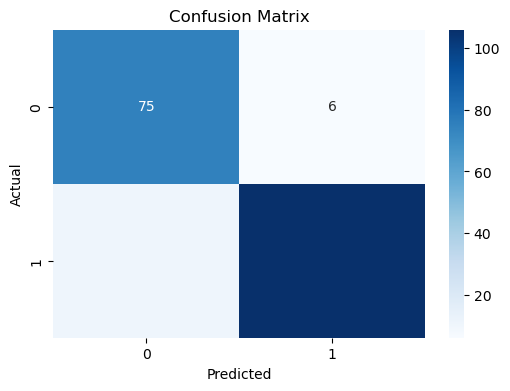

In [27]:
# Step 6: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [28]:
# Step 5: Save the final model to a .pkl file using joblib
joblib.dump(best_model, 'xgboost.pkl')
print("Model saved as 'xgboost.pkl'")

Model saved as 'xgboost.pkl'
